<h1>ZMGSN Lista 2. - Variational Autoencoder (VAE)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu VAE</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu VAE</li>
<li>Zaimplementować koder (ang. encoder) kompatybilny z dekoderem wykorzystanym w poniższym eksperymencie</li>
<li>Połączyć zaimplementowany koder z dostępnym dekoderem w celu opracowania autokodera (ang. autoencoder - AE)</li>
<li>Opracować pętlę uczącą dopasowaną do sieci typu Autoencoder</li>
<li>Dokonać ewaluacji opracowanej sieci typu Autoencoder</li>
<li>Porównać wyniki działania modelu AE z modelem VAE</li>
<li>Dokonać ewaluacji innych wariantów sieci VAE, np. Concrete VAE, BVAE, NVAE itp.</li>
<li>Opracować procedurę ewaluacji jakości działania modeli AE, VAE i innych rozważanych wariantów, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [8]:
torch.manual_seed(0)

<h2>Konfiguracja stylu prezentacji wykresów generowanych za pomocą biblioteki Matplotlib</h2>

In [9]:
plt.rcParams['figure.dpi'] = 200

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<h2>Określenie wymiarowości ukrytej przestrzeni wektorowej, w której będą przechowywane ukryte reprezentacje danych wejściowych</h2>

In [11]:
latent_dims = 2

<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [12]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 71689676.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16242383.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26365235.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20266519.97it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



<h2>Deklaracja podstawowej klasy kodera wariacyjnego (ang. variational encoder)<h2>

In [13]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # umożliwienie próbkowania wielowymiarowego rozkładu na karcie graficznej
        self.N.loc = self.N.loc.cuda() if torch.cuda.is_available() else self.N.loc
        self.N.scale = self.N.scale.cuda() if torch.cuda.is_available() else self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (((sigma**2 + mu**2) / 2) - torch.log(sigma) - 1/2).sum()
        return z

<h2>Deklaracja podstawowej klasy dekodera</h2>

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

<h2>Deklaracja podstawowej klasy wariacyjnego autokodera (ang. variational autoencoder - VAE)</h2>

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

<h2>Przykładowa pętla ucząca</h2>

In [16]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        loss_list = np.array([])
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
            loss_list = np.append(loss_list, loss.item())
        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")
    return autoencoder

<h2>Inicjalizacja sieci VAE i uruchomienie procesu uczenia</h2>

In [17]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

Epoch [1/20], avg_loss: 6146.3626
Epoch [2/20], avg_loss: 5391.2787
Epoch [3/20], avg_loss: 5258.2085
Epoch [4/20], avg_loss: 5179.5769
Epoch [5/20], avg_loss: 5124.4214
Epoch [6/20], avg_loss: 5080.7833
Epoch [7/20], avg_loss: 5043.1000
Epoch [8/20], avg_loss: 5013.3857
Epoch [9/20], avg_loss: 4987.3651
Epoch [10/20], avg_loss: 4964.3418
Epoch [11/20], avg_loss: 4939.4661
Epoch [12/20], avg_loss: 4920.0390
Epoch [13/20], avg_loss: 4904.0195
Epoch [14/20], avg_loss: 4885.9580
Epoch [15/20], avg_loss: 4869.7337
Epoch [16/20], avg_loss: 4855.6376
Epoch [17/20], avg_loss: 4839.8037
Epoch [18/20], avg_loss: 4830.0118
Epoch [19/20], avg_loss: 4817.0133
Epoch [20/20], avg_loss: 4802.9392


<h2>Funkcja pomocniczna służąca do wizualizacji ukrytej wektorowej reprezentacji (ang. latent vector) danych wejściowych</h2>

In [18]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

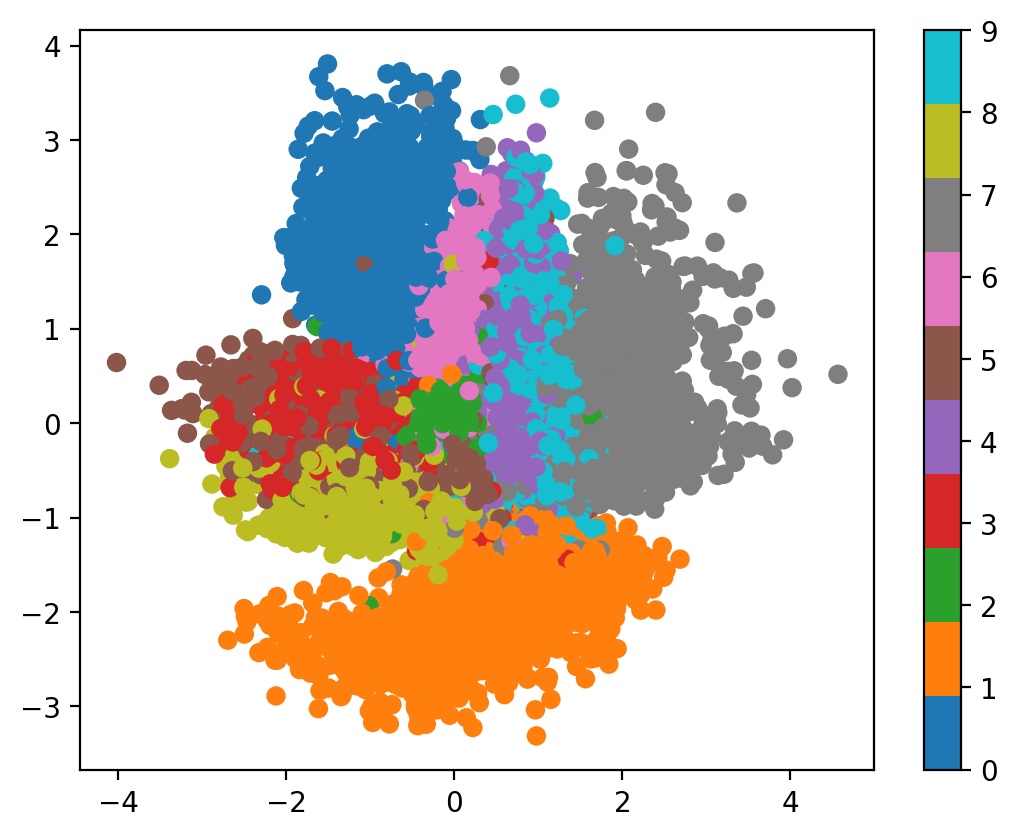

In [19]:
plot_latent(vae, data)

<h2>Funkcja pomocniczna służąca do jednostajnego próbkowania wyuczonej przestrzeni wektorowej (ang. latent vector space), z której sieć VAE czerpie ukryte reprezentacje wektorowe danych wejściowych</h2>

In [20]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

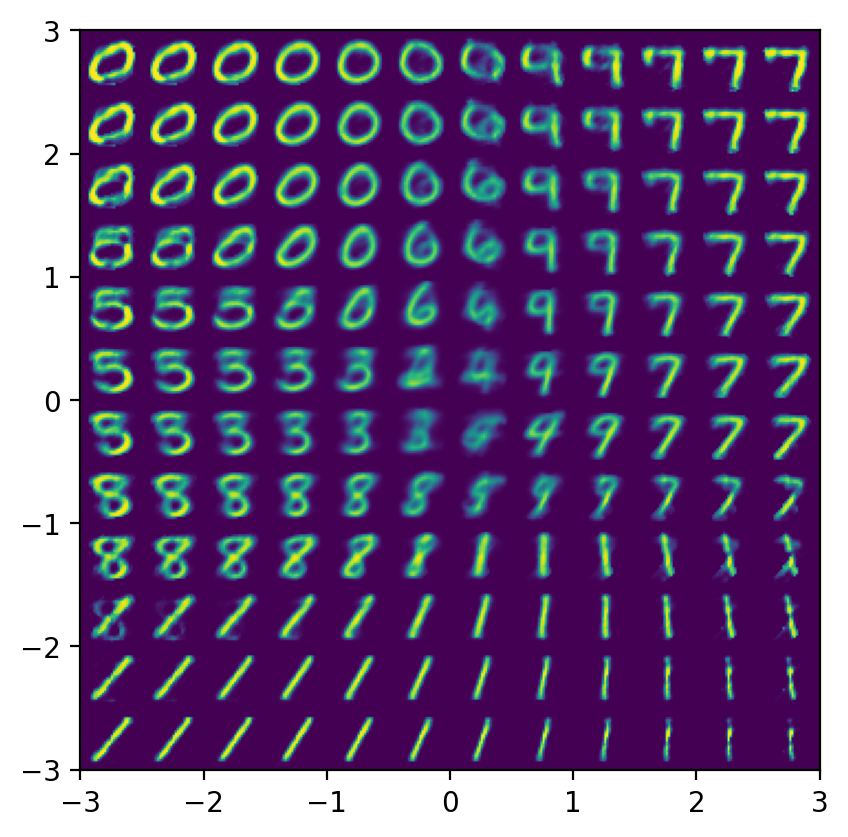

In [21]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

<h2>Funkcja pomocnicza pozwalająca na interpolację</h2>

In [22]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [23]:
# Uzyskanie pakietu próbek (ang. batch) ze zbioru uczącego
# x, y = data.__iter__().next()
x, y = next(iter(data))

# Uzyskanie próbki należącej do klasy "1"
x_1 = x[y == 1][1].to(device)

# Uzyskanie próbki należącej do klasy "0"
x_2 = x[y == 0][1].to(device)

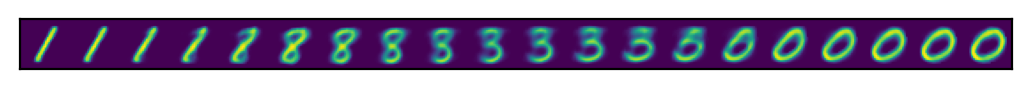

In [24]:
interpolate(vae, x_1, x_2, n=20)